Obtain forecasts for Trajectron on CARLA or NuScenes data. Provides:

- predictions overlaid on preprocessed input bitmap (does not use the NuScenes map)
- predictions coded by latent values

When loading earlier versions of CARLA data, checkout tag `v1.0` from `carla-collect` and add it to the Python path
https://github.com/fireofearth/carla-collect

In [2]:
%matplotlib inline
import os
import sys
import json
from glob import glob
from timeit import default_timer as timer

from tqdm import tqdm
import numpy as np
import torch
import dill
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib.animation as animation

import utility as util
from collect.visualize.trajectron import render_scene
from collect.predict.trajectron import generate_vehicle_latents

from helper import load_model, prediction_output_to_trajectories
from model.dataset import get_timesteps_data
from model.model_utils import ModeKeys

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

Search datasets

In [3]:
search_datasets = False
rootdir = "../../../.."
glob(f"{ rootdir }/*/*.pkl") if search_datasets else []

[]

Load a dataset

In [4]:
dataset_0 = util.AttrDict(
    test_set_path='../../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset with bitmap matching NuScenes")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset_4 = util.AttrDict(
        test_set_path=f"{ rootdir }/carla_v3_0_1_dataset/carla_test_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        v2_bitmap=True)

dataset_5 = util.AttrDict(
        test_set_path=f"{ rootdir }/carla_v3-1_dataset/v3-1_split1_test.pkl",
        name='v3-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_6 = util.AttrDict(
        test_set_path=f"{ rootdir }/carla_v3-1-1_dataset/v3-1-1_split1_test.pkl",
        name='v3-1-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_7 = util.AttrDict(
        test_set_path=f"{ rootdir }/v3-1-2_split1_test.pkl",
        name='v3-1-2_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_8 = util.AttrDict(
    test_set_path=f"{rootdir}/carla_dataset_v4-1/v4-1_split1_test.pkl",
    name="v4-1",
    desc="CARLA 0.9.13 synthesized dataset all maps"
)

dataset_9 = util.AttrDict(
    test_set_path=f"{rootdir}/carla_dataset_v4-2-1/v4-2-1_split1_test.pkl",
    name="v4-2-1",
    desc="CARLA 0.9.13 synthesized dataset Town03 only"
)

dataset = dataset_8
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

CARLA 0.9.13 synthesized dataset all maps


Search models

In [5]:
search_models = False
models_dir = "../models"
[x[0] for x in os.walk(models_dir)] if search_models else None

Load a model

In [6]:
model_1 = util.AttrDict(
        path='../models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='../models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='../models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='../models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='../models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_9 = util.AttrDict(
        path='../models/models_19_Jul_2021_21_09_20_carla_v3_0_1_base_dist_ph6',
        desc="Base model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_10 = util.AttrDict(
        path='../models/models_19_Jul_2021_22_45_29_carla_v3_0_1_base_distmap_ph6',
        desc="Base +Map model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_11 = util.AttrDict(
        path='../models/models_20_Jul_2021_11_48_11_carla_v3_0_1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8 "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_12 = util.AttrDict(
        path='../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8, K=25 "
             "(trained on carla v3-1 dataset)")

model_13 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_37_17_carla_v3-1_base_distmap_K20_ph8',
        desc="Base +Map model with heading fix, PH=8, K=20 "
             "(trained on carla v3-1 dataset)")

model_14 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_38_46_carla_v3-1_base_distmap_K15_ph8',
        desc="Base +Map model with heading fix, PH=8, K=15 "
             "(trained on carla v3-1 dataset)")

model_15 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_38_20_carla_v3-1_base_distmap_K10_ph8',
        desc="Base +Map model with heading fix, PH=8, K=10 "
             "(trained on carla v3-1 dataset)")

model_16 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_39_52_carla_v3-1_base_distmap_K5_ph8',
        desc="Base +Map model with heading fix, PH=8, K=5 "
             "(trained on carla v3-1 dataset)")

model_17 = util.AttrDict(
        path='../models/20210801/models_01_Aug_2021_20_02_57_carla_v3-1-1_base_distmapV3_ph8',
        desc="Base +MapV2 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_18 = util.AttrDict(
        path='../models/20210802/models_02_Aug_2021_19_29_27_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_19 = util.AttrDict(
        path='../models/20210803/models_03_Aug_2021_13_42_51_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_20 = util.AttrDict(
        path='../models/20210804/models_04_Aug_2021_19_14_01_carla_v3-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on carla v3-1 dataset)")

model_21 = util.AttrDict(
        path='../models/20210803/models_05_Aug_2021_21_29_38_carla_v3-1-1_base_distmapV4_K5_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=5 "
             "(trained on smaller carla v3-1-1 dataset)")

model_22 = util.AttrDict(
        path=f'{models_dir}/20210816/models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=5 "
             "(trained on carla v3-1-2 dataset w/ rebalancing)")

model_23  = util.AttrDict(
    path=f"{models_dir}/20220326/models_26_Mar_2022_23_31_28_carla_v4-1_base_distmapV4_modfm_K15_ph8",
    desc="Base +MapV4-1 model with heading fix, rebalancing, PH=8, K=5 (trained on CARLA 0.9.13 all maps)"
)

model_24  = util.AttrDict(
    path=f"{models_dir}/20220326/models_27_Mar_2022_04_52_55_carla_v4-2-1_base_distmapV4_modfm_K15_ph8",
    desc="Base +MapV4-1 model with heading fix, rebalancing, PH=8, K=5 (trained on CARLA 0.9.13 Town03)"
)

model = model_23
eval_stg, hyp = load_model(model.path, eval_env, ts=20)#, device='cuda')
print(model.desc)


Loading from ../models/20220326/models_26_Mar_2022_23_31_28_carla_v4-1_base_distmapV4_modfm_K15_ph8/model_registrar-20.pt
Loaded!

Base +MapV4-1 model with heading fix, rebalancing, PH=8, K=5 (trained on CARLA 0.9.13 all maps)


### Combining forecast and map

In [14]:
num_samples = 200
ph = 8

def get_scene_2():
    """example where many models are not multi-modal in v3-1-1 dataset"""
    idx, t = 28, 7
    return eval_scenes[idx], t
scene, t = get_scene_2()

scene = eval_scenes[2]
t = 10

timesteps = np.array([t])

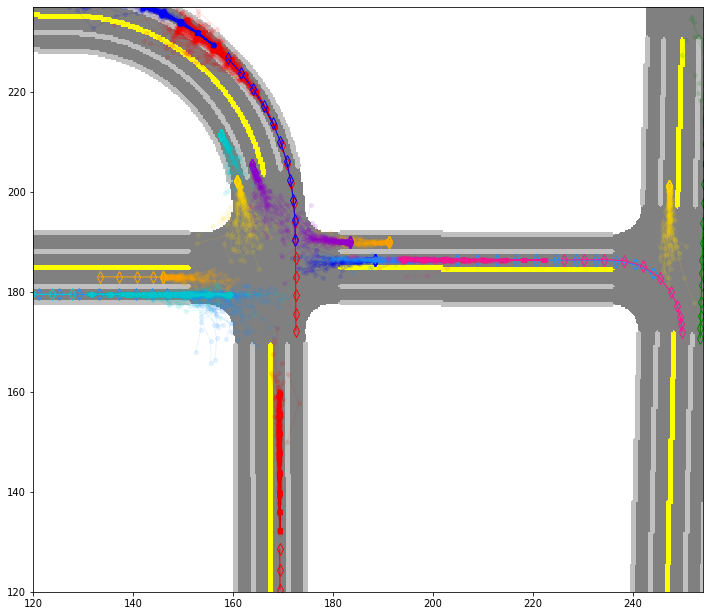

In [15]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_scene(ax, scene)

should_show_predictions = True
should_show_gt = False

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

    if should_show_gt:
        ax.plot(player_future[:,0], player_future[:,1],
                    marker='s', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    if should_show_predictions:
        for row in player_predict[0]:
            ax.plot(row[:,0], row[:,1],
                    marker='o', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, alpha=0.1, markersize=4)

extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = True
if should_zoom_in:
    zoom = np.array([120, 120])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
None

### Plot predictions by latent

In [30]:
def plot_behavior(scene, z, zz, predictions, nodes):
    latent_size = zz.shape[2]
#     coords = predictions.reshape(-1, 2)
#     x_max, y_max = np.amax(coords, axis=0)
#     x_min, y_min = np.amin(coords, axis=0)
    figwidth  = 20.
#     figheight = figwidth*(13. / 2.)*(y_max - y_min)/(x_max - x_min)
    figheight = (float(latent_size)/25.)*figwidth*(13. / 2.)*(scene.y_size)/(scene.x_size)
    
    _, histories_dict, _ = \
            prediction_output_to_trajectories(
                predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)
    
    n_vehicles = len(nodes)
    colors = cm.nipy_spectral(np.linspace(0, 1, latent_size))
    fig, axes = plt.subplots(latent_size // 2 + latent_size % 2, 2,
            figsize=(figwidth, figheight))
    fig.tight_layout()
    
    for behavior in range(0, latent_size):
        ax = axes[behavior // 2][behavior % 2]
        color = colors[behavior]
        label=f"z = {behavior}"
        for idx, node in enumerate(nodes):
            zn = z[idx]
            pn = predictions[idx]
            mask = zn == behavior
            zn = zn[mask]
            pn = pn[mask]
            player_past = histories_dict[t][node]
            player_past = np.vstack(
                    (player_past, player_past[-1][None] + 5))
            
            ax.plot(player_past[:,0], player_past[:,1],
                    color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1)
            
            for jdx in range(zn.shape[0]):
                ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                        marker='o', color=color,
                        linewidth=1, alpha=0.2, markersize=4,
                        label=label)
                label=None
#         ax.set_xlim([x_min, x_max])
#         ax.set_ylim([y_min, y_max])
        ax.set_xlim([0, scene.x_size])
        ax.set_ylim([0, scene.y_size])
        ax.set_aspect('equal')
        ax.legend(loc='upper right')
        ax.set_facecolor("grey")
#     axes[-1,-1].set_xlim([x_min, x_max])
#     axes[-1,-1].set_ylim([y_min, y_max])
    axes[-1,-1].set_xlim([0, scene.x_size])
    axes[-1,-1].set_ylim([0, scene.y_size])
    axes[-1,-1].set_visible(False)
    return fig, axes

In [31]:
with torch.no_grad():
    z,zz, predictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
            eval_stg, scene, t, ph, num_samples=500,
            z_mode=False, gmm_mode = False,
            full_dist = False, all_z_sep = False)

Plot predictions color coded by latent value

18
VEHICLE/532
VEHICLE/ego
VEHICLE/637
VEHICLE/627
VEHICLE/619
VEHICLE/613
VEHICLE/606
VEHICLE/600
VEHICLE/587
VEHICLE/588
VEHICLE/536
VEHICLE/539
VEHICLE/534
VEHICLE/556
VEHICLE/571
VEHICLE/551
VEHICLE/541
VEHICLE/616


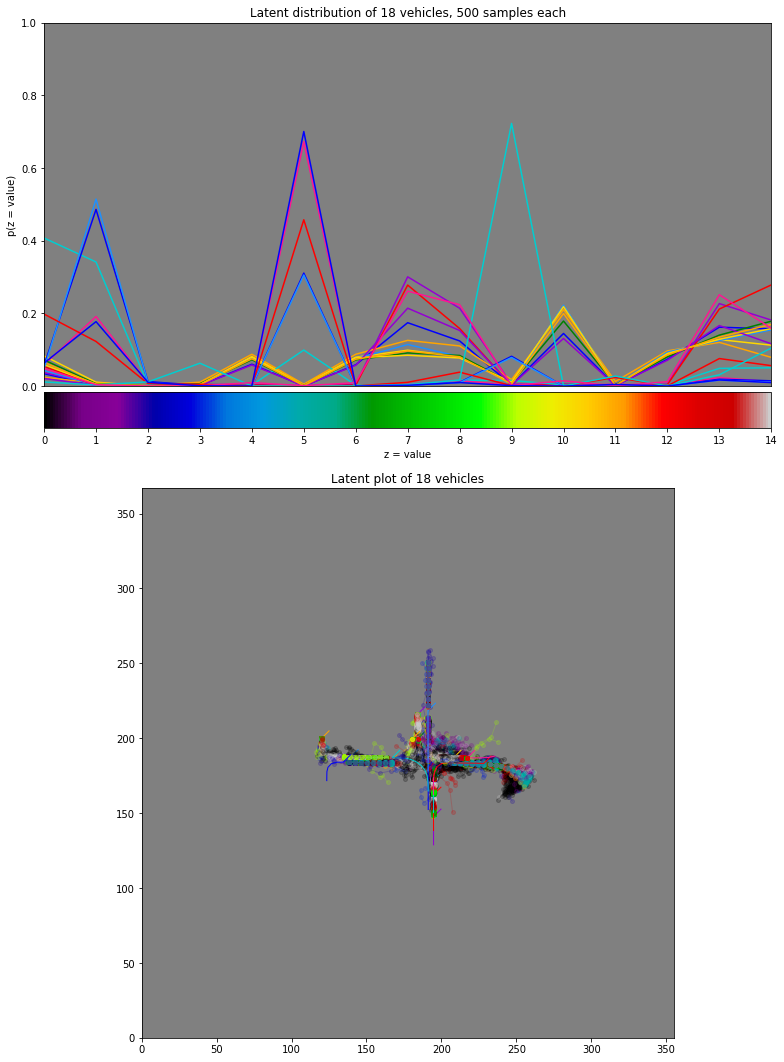

In [32]:
latent_size = zz.shape[2]
latent_colors = cm.nipy_spectral(np.linspace(0, 1, latent_size))
z_counts = np.sum(zz, axis=0) / z.shape[1]
n_vehicles = len(nodes)
print(n_vehicles)

_, histories_dict, _ = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

fig, (ax1, ax) = plt.subplots(2, 1, figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(latent_probs):
    ax1.plot(range(latent_size), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, latent_size - 1])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles, {z.shape[1]} samples each")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, latent_size))
plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

for idx, node in enumerate(nodes):
    print(node)
    player_past = histories_dict[t][node]
    player_past = np.vstack((player_past, player_past[-1][None] + 5))

    ax.plot(player_past[:,0], player_past[:,1],
            color=AGENT_COLORS[idx % NCOLORS],
            linewidth=1)

    # latent variable z corresponding to vehicle.
    zn = z[idx]
    pn = predictions[idx]
    for jdx in range(zn.shape[0]):
        color = latent_colors[zn[jdx]]
        ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                marker='o',
                 color=color,
                linewidth=1, alpha=0.2, markersize=4)

ax.set_facecolor("grey")
ax.set_title(f"Latent plot of {n_vehicles} vehicles")
ax.set_aspect('equal')
ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()

Plot predictions separately for each latent value

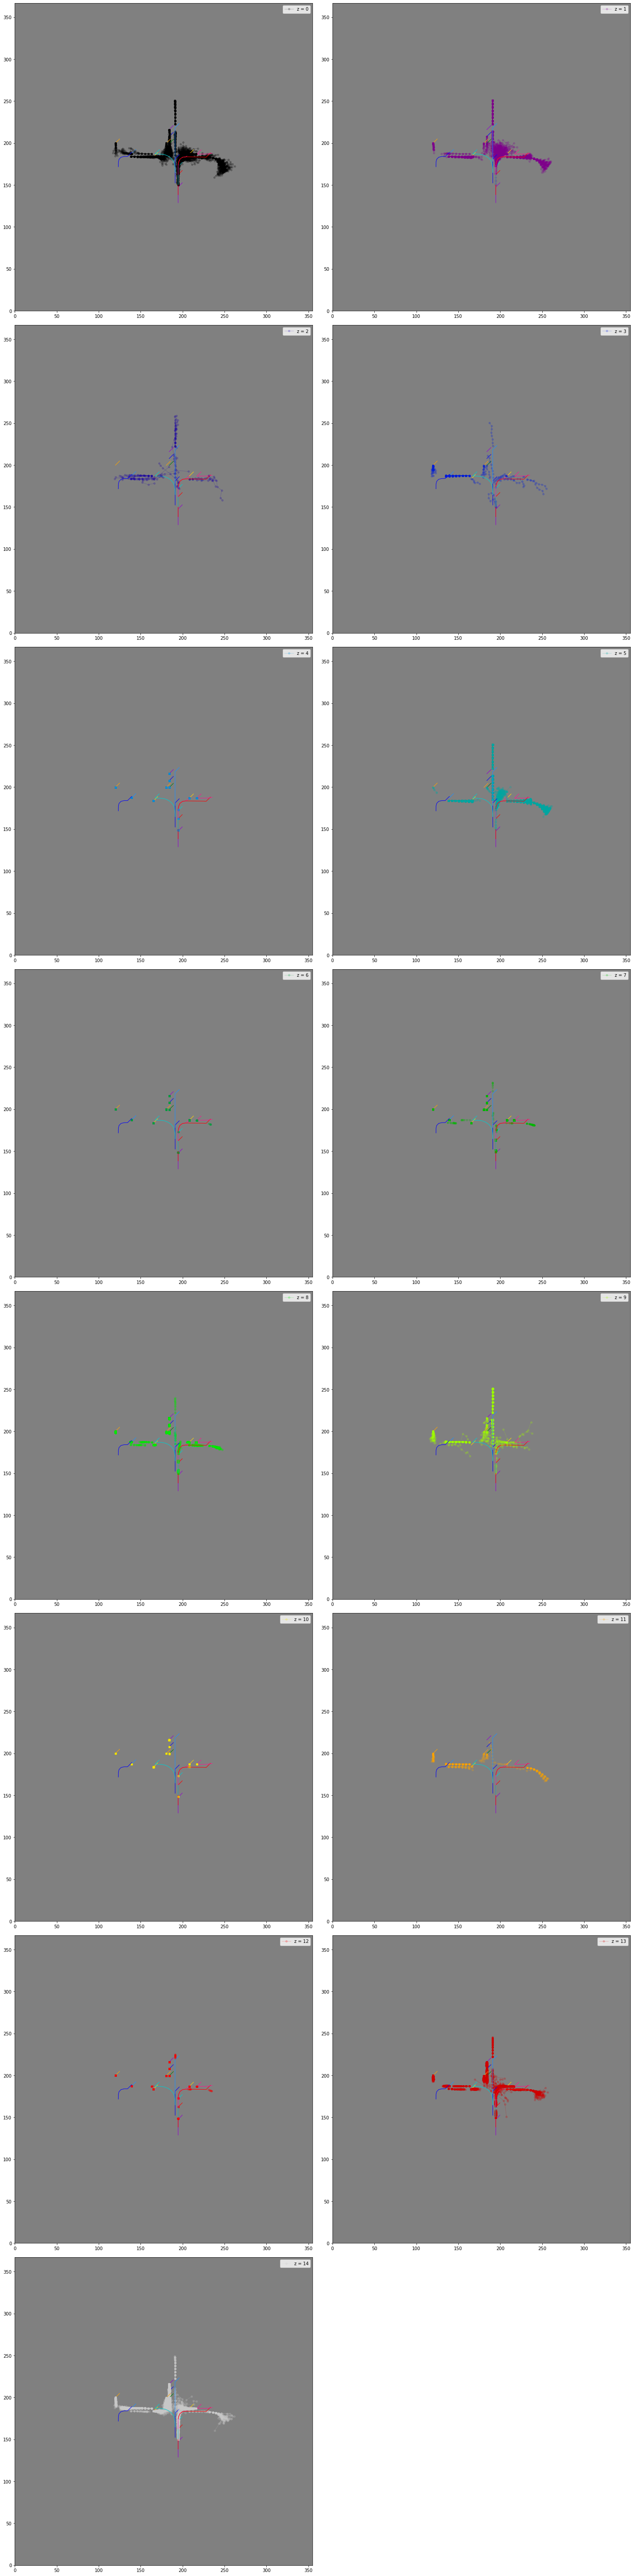

In [33]:
fig, ax = plot_behavior(scene, z, zz, predictions, nodes)

Animation of predictions

In [15]:
def get_predictions_across_scene(scene):
    results = {}
    with torch.no_grad():
        for t in tqdm(range(1, scene.timesteps)):
            z, zz, zpredictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
                    eval_stg, scene, t, ph, num_samples=100)

            prediction_dict, histories_dict, futures_dict = \
                    prediction_output_to_trajectories(
                        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

            result = util.AttrDict(z=z, zz=zz, zpredictions=zpredictions, nodes=nodes, latent_probs=latent_probs,
                    prediction_dict=prediction_dict, histories_dict=histories_dict, futures_dict=futures_dict)

            results[t] = result
    return results


In [16]:
results = get_predictions_across_scene(scene)

100%|██████████| 31/31 [00:02<00:00, 14.97it/s]


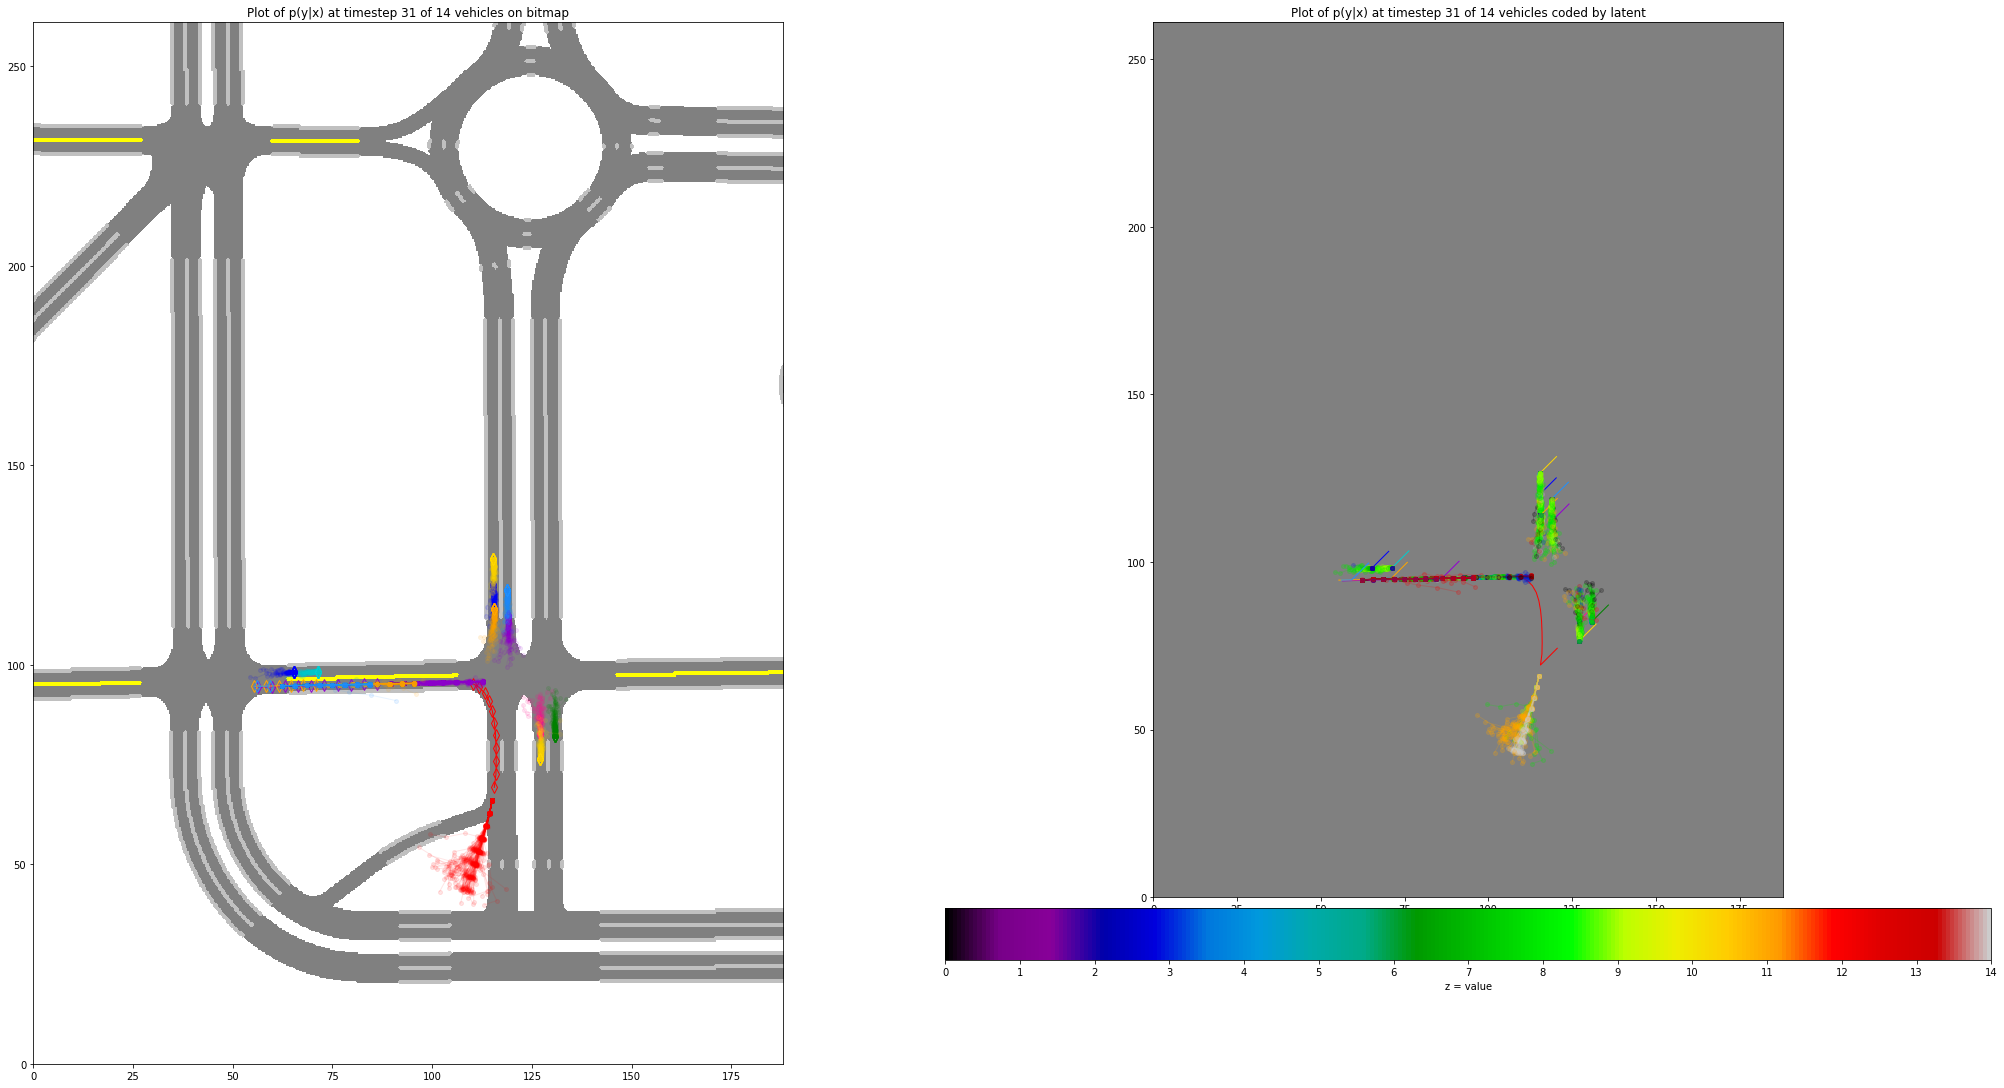

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(30,15))
axes = axes.ravel()

plot_artists = []
plot_artists_across_scenes = {}
def generate_plots_for_timestep(t):
    global plot_artists
    plot_artists_across_scenes[t] = []
    if t < 1 or t >= scene.timesteps:
        return
    
    result = results[t]
    z, zz, zpredictions, nodes, latent_probs, prediction_dict, histories_dict, futures_dict \
            = result.z, result.zz, result.zpredictions, result.nodes, result.latent_probs, \
                result.prediction_dict, result.histories_dict, result.futures_dict
    n_vehicles = len(nodes)

    # Prediction on map
    ax = axes[0]
    render_roads(ax, scene)
    for idx, node in enumerate(nodes):
        player_future = futures_dict[t][node]
        player_past = histories_dict[t][node]
        player_predict = prediction_dict[t][node]

        plot = ax.plot(player_future[:,0], player_future[:,1],
                    marker='s', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
        plot_artists.extend(plot)
        plot_artists_across_scenes[t].extend(plot)
        plot = ax.plot(player_past[:,0], player_past[:,1],
                    marker='d', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
        plot_artists.extend(plot)
        plot_artists_across_scenes[t].extend(plot)
        for row in player_predict[0]:
            plot = ax.plot(row[:,0], row[:,1],
                    marker='o', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, alpha=0.1, markersize=4)
            plot_artists.extend(plot)
            plot_artists_across_scenes[t].extend(plot)

    ax.set_title(f"Plot of p(y|x) at timestep {t} of {n_vehicles} vehicles on bitmap")

    # Prediction by latent
    ax = axes[1]
    latent_colors = cm.nipy_spectral(np.linspace(0, 1, hyp['K']))
    # z_counts = np.sum(zz, axis=0) / z.shape[1]

    for idx, node in enumerate(nodes):
        player_past = histories_dict[t][node]
        player_past = np.vstack((player_past, player_past[-1][None] + 5))
        plot = ax.plot(player_past[:,0], player_past[:,1],
                color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1)
        plot_artists.extend(plot)
        plot_artists_across_scenes[t].extend(plot)

        # latent variable z corresponding to vehicle.
        zn = z[idx]
        pn = zpredictions[idx]
        for jdx in range(zn.shape[0]):
            color = latent_colors[zn[jdx]]
            plot = ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                    marker='o',
                     color=color,
                    linewidth=1, alpha=0.2, markersize=4)
            plot_artists.extend(plot)
            plot_artists_across_scenes[t].extend(plot)

    ax.set_title(f"Plot of p(y|x) at timestep {t} of {n_vehicles} vehicles coded by latent")

generate_plots_for_timestep(0)
scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, hyp['K']))
plt.colorbar(scalarmappaple, ax=axes[1], orientation='horizontal',
             pad=0.01,
             ticks=range(0, hyp['K']),
             label="z = value")
axes[1].set_facecolor("grey")
axes[1].set_aspect('equal')
for ax in axes:
    ax.set_xlim([0, scene.x_size])
    ax.set_ylim([0, scene.y_size])
fig.tight_layout()

def predictions_of_frame(t, *args):
    global plot_artists
    for a in plot_artists:
            a.remove()
    plot_artists = []
    if t not in plot_artists_across_scenes:
        generate_plots_for_timestep(t)
    return plot_artists_across_scenes[t]

# Construct the animation, using the update function as the animation director.
anim = animation.FuncAnimation(fig, predictions_of_frame, frames=scene.timesteps,
                               interval=500, blit=False, repeat=False)
writer = animation.FFMpegWriter(fps=1, codec="h264", extra_args=["-preset", "veryslow","-crf","0"])
anim.save(f"predict_scene.mp4", writer=writer)
plt.show()